To run this, press "*Runtime*" and press "*Run all*" on a **free** Tesla T4 Google Colab instance!
<div class="align-center">
<a href="https://unsloth.ai/"><img src="https://github.com/unslothai/unsloth/raw/main/images/unsloth%20new%20logo.png" width="115"></a>
<a href="https://discord.gg/unsloth"><img src="https://github.com/unslothai/unsloth/raw/main/images/Discord button.png" width="145"></a>
<a href="https://docs.unsloth.ai/"><img src="https://github.com/unslothai/unsloth/blob/main/images/documentation%20green%20button.png?raw=true" width="125"></a></a> Join Discord if you need help + ⭐ <i>Star us on <a href="https://github.com/unslothai/unsloth">Github</a> </i> ⭐
</div>

To install Unsloth on your own computer, follow the installation instructions on our Github page [here](https://docs.unsloth.ai/get-started/installing-+-updating).

You will learn how to do [data prep](#Data), how to [train](#Train), how to [run the model](#Inference), & [how to save it](#Save)


### News

Read our **[Qwen3 Guide](https://docs.unsloth.ai/basics/qwen3-how-to-run-and-fine-tune)** and check out our new **[Dynamic 2.0](https://docs.unsloth.ai/basics/unsloth-dynamic-2.0-ggufs)** quants which outperforms other quantization methods!

Visit our docs for all our [model uploads](https://docs.unsloth.ai/get-started/all-our-models) and [notebooks](https://docs.unsloth.ai/get-started/unsloth-notebooks).


### Installation

In [1]:
%%capture
import os
if "COLAB_" not in "".join(os.environ.keys()):
    !pip install unsloth
else:
    # Do this only in Colab notebooks! Otherwise use pip install unsloth
    !pip install --no-deps bitsandbytes accelerate xformers==0.0.29.post3 peft trl==0.15.2 triton cut_cross_entropy unsloth_zoo
    !pip install sentencepiece protobuf datasets huggingface_hub hf_transfer
    !pip install --no-deps unsloth

### Unsloth

In [1]:
from unsloth import FastLanguageModel
import torch

fourbit_models = [
    "unsloth/Qwen3-1.7B-unsloth-bnb-4bit", # Qwen 14B 2x faster
    "unsloth/Qwen3-4B-unsloth-bnb-4bit",
    "unsloth/Qwen3-8B-unsloth-bnb-4bit",
    "unsloth/Qwen3-14B-unsloth-bnb-4bit",
    "unsloth/Qwen3-32B-unsloth-bnb-4bit",

    # 4bit dynamic quants for superior accuracy and low memory use
    "unsloth/gemma-3-12b-it-unsloth-bnb-4bit",
    "unsloth/Phi-4",
    "unsloth/Llama-3.1-8B",
    "unsloth/Llama-3.2-3B",
    "unsloth/orpheus-3b-0.1-ft-unsloth-bnb-4bit" # [NEW] We support TTS models!
] # More models at https://huggingface.co/unsloth

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/Qwen3-14B",
    max_seq_length = 2048,   # Context length - can be longer, but uses more memory
    load_in_4bit = True,     # 4bit uses much less memory
    load_in_8bit = False,    # A bit more accurate, uses 2x memory
    full_finetuning = False, # We have full finetuning now!
    # token = "hf_...",      # use one if using gated models
)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
==((====))==  Unsloth 2025.5.1: Fast Qwen3 patching. Transformers: 4.51.3.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 7.5. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

We now add LoRA adapters so we only need to update 1 to 10% of all parameters!

In [2]:
model = FastLanguageModel.get_peft_model(
    model,
    r = 32,           # Choose any number > 0! Suggested 8, 16, 32, 64, 128
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj",],
    lora_alpha = 32,  # Best to choose alpha = rank or rank*2
    lora_dropout = 0, # Supports any, but = 0 is optimized
    bias = "none",    # Supports any, but = "none" is optimized
    # [NEW] "unsloth" uses 30% less VRAM, fits 2x larger batch sizes!
    use_gradient_checkpointing = "unsloth", # True or "unsloth" for very long context
    random_state = 3407,
    use_rslora = False,   # We support rank stabilized LoRA
    loftq_config = None,  # And LoftQ
)

Unsloth 2025.5.1 patched 40 layers with 40 QKV layers, 40 O layers and 40 MLP layers.


<a name="Data"></a>
### Data Prep
Qwen3 has both reasoning and a non reasoning mode. So, we should use 2 datasets:

1. We use the [Open Math Reasoning]() dataset which was used to win the [AIMO](https://www.kaggle.com/competitions/ai-mathematical-olympiad-progress-prize-2/leaderboard) (AI Mathematical Olympiad - Progress Prize 2) challenge! We sample 10% of verifiable reasoning traces that used DeepSeek R1, and whicht got > 95% accuracy.

2. We also leverage [Maxime Labonne's FineTome-100k](https://huggingface.co/datasets/mlabonne/FineTome-100k) dataset in ShareGPT style. But we need to convert it to HuggingFace's normal multiturn format as well.

In [ ]:
!pip install datasets==2.18.0


In [3]:
from datasets import load_dataset

dataset = load_dataset("vahidhoseini/persian-Negotiations", split="train")
dataset = dataset.train_test_split(test_size=0.7, seed=42)['train']


In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Let's see the structure of both datasets:

In [4]:
dataset[0]

{'instruction': 'یک نوع لایه مورد استفاده در شبکه های عصبی را نام ببرید.',
 'input': '',
 'output': 'یکی از انواع لایه های مورد استفاده در شبکه های عصبی، لایه کانولوشن است.'}

We now convert the reasoning dataset into conversational format:

1.   List item
2.   List item



In [5]:
def generate_conversation(examples):
    instructions = examples["instruction"]
    inputs = examples["input"]
    outputs = examples["output"]
    conversations = []

    for instruction, input_text, output in zip(instructions, inputs, outputs):
        if input_text.strip():
            prompt = f"{instruction}\n\n{input_text}"
        else:
            prompt = instruction
        conversations.append([
            {"role": "user", "content": prompt},
            {"role": "assistant", "content": output},
        ])

    return { "conversations": conversations }


In [6]:
conversations = tokenizer.apply_chat_template(
    dataset.map(generate_conversation, batched = True)["conversations"],
    tokenize = False,
)

Map:   0%|          | 0/10431 [00:00<?, ? examples/s]

Let's see the first transformed row:

In [7]:
conversations[0]

'<|im_start|>user\nیک نوع لایه مورد استفاده در شبکه های عصبی را نام ببرید.<|im_end|>\n<|im_start|>assistant\n<think>\n\n</think>\n\nیکی از انواع لایه های مورد استفاده در شبکه های عصبی، لایه کانولوشن است.<|im_end|>\n'

Next we take the non reasoning dataset and convert it to conversational format as well.

We have to use Unsloth's `standardize_sharegpt` function to fix up the format of the dataset first.

Let's see the first row

Now let's see how long both datasets are:

The non reasoning dataset is much longer. Let's assume we want the model to retain some reasoning capabilities, but we specifically want a chat model.

Let's define a ratio of chat only data. The goal is to define some mixture of both sets of data.

Let's select 25% reasoning and 75% chat based:

Let's sample the reasoning dataset by 25% (or whatever is 100% - chat_percentage)

Finally combine both datasets:

In [8]:
def flatten_conversations(example):
    chat = example["conversations"]
    merged = ""
    for message in chat:
        merged += f"<|im_start|>{message['role']}\n{message['content']}<|im_end|>\n"
    return {"text": merged}


In [9]:
from datasets import Dataset

# تبدیل لیست مکالمه‌ها به دیتاست قابل استفاده در SFTTrainer
conversation_dataset = Dataset.from_dict({
    "text": conversations
})


<a name="Train"></a>
### Train the model
Now let's use Huggingface TRL's `SFTTrainer`! More docs here: [TRL SFT docs](https://huggingface.co/docs/trl/sft_trainer). We do 60 steps to speed things up, but you can set `num_train_epochs=1` for a full run, and turn off `max_steps=None`.

In [10]:
from trl import SFTTrainer
from transformers import TrainingArguments
from unsloth import is_bfloat16_supported

trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = conversation_dataset,
    eval_dataset = None,
    dataset_text_field = "text",
    max_seq_length = 1024,  # اگر از قبل تعریف شده
    dataset_num_proc = 2,
    packing = False,
    args = TrainingArguments(
        per_device_train_batch_size = 2,
        gradient_accumulation_steps = 4,
        warmup_steps = 5,
        max_steps = 60,
        learning_rate = 2e-4,
        fp16 = not is_bfloat16_supported(),
        bf16 = is_bfloat16_supported(),
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir = "outputs",
        report_to = "none",
    ),
)


Unsloth: Tokenizing ["text"] (num_proc=2):   0%|          | 0/10431 [00:00<?, ? examples/s]

In [ ]:
# @title Show current memory stats
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

GPU = Tesla T4. Max memory = 14.741 GB.
11.898 GB of memory reserved.


Let's train the model! To resume a training run, set `trainer.train(resume_from_checkpoint = True)`

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 10,431 | Num Epochs = 1 | Total steps = 60
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 4 x 1) = 8
 "-____-"     Trainable parameters = 128,450,560/14,000,000,000 (0.92% trained)


Unsloth: Will smartly offload gradients to save VRAM!


Step,Training Loss
1,1.307700
2,1.447000
3,1.333000
4,1.110500
5,1.086500
6,1.138100
7,1.050900
8,1.112800
9,1.056400
10,1.133300


,loss,grad_norm,learning_rate,epoch,step,train_runtime,train_samples_per_second,train_steps_per_second,total_flos,train_loss
0,1.3077,0.300350,0.000000,0.000767,1,NaN,NaN,NaN,NaN,NaN
1,1.4470,0.315932,0.000040,0.001534,2,NaN,NaN,NaN,NaN,NaN
2,1.3330,0.334400,0.000080,0.002301,3,NaN,NaN,NaN,NaN,NaN
3,1.1105,0.247339,0.000120,0.003067,4,NaN,NaN,NaN,NaN,NaN
4,1.0865,0.303500,0.000160,0.003834,5,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
56,0.8644,0.192355,0.000015,0.043712,57,NaN,NaN,NaN,NaN,NaN
57,0.9897,0.338949,0.000011,0.044479,58,NaN,NaN,NaN,NaN,NaN
58,0.9516,0.228611,0.000007,0.045245,59,NaN,NaN,NaN,NaN,NaN
59,0.7851,0.183569,0.000004,0.046012,60,NaN,NaN,NaN,NaN,NaN


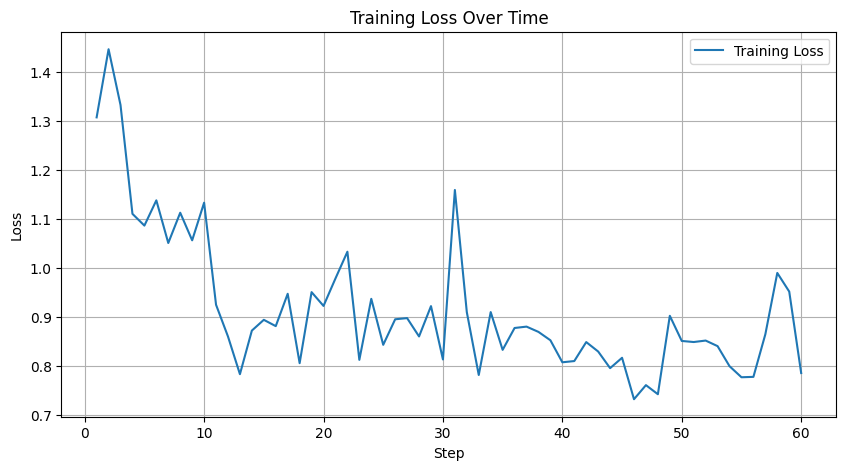

In [11]:
import matplotlib.pyplot as plt
import pandas as pd

# پس از آموزش
trainer_stats = trainer.train()

# استخراج لاگ‌های تاریخی
logs = trainer.state.log_history

# تبدیل به DataFrame برای راحتی
log_df = pd.DataFrame(logs)

# نمایش جدول لاگ‌ها (metrics مثل loss، eval_accuracy و ...)
display(log_df)

# رسم نمودار loss
if 'loss' in log_df.columns:
    plt.figure(figsize=(10,5))
    plt.plot(log_df["step"], log_df["loss"], label="Training Loss")
    plt.xlabel("Step")
    plt.ylabel("Loss")
    plt.title("Training Loss Over Time")
    plt.legend()
    plt.grid(True)
    plt.show()

# اگر accuracy در لاگ‌ها هست، رسم accuracy
if 'eval_accuracy' in log_df.columns:
    plt.figure(figsize=(10,5))
    plt.plot(log_df["step"], log_df["eval_accuracy"], label="Eval Accuracy", color="green")
    plt.xlabel("Step")
    plt.ylabel("Accuracy")
    plt.title("Evaluation Accuracy Over Time")
    plt.legend()
    plt.grid(True)
    plt.show()


#15 سال دیگ هادی میکشه کنار؟

In [ ]:
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 249 | Num Epochs = 1 | Total steps = 30
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 4 x 1) = 8
 "-____-"     Trainable parameters = 128,450,560/14,000,000,000 (0.92% trained)


Unsloth: Will smartly offload gradients to save VRAM!


Step,Training Loss
1,2.351100
2,2.919800
3,2.510100
4,2.555000
5,2.162700
6,2.017100
7,1.767600


Step,Training Loss
1,2.351100
2,2.919800
3,2.510100
4,2.555000
5,2.162700
6,2.017100
7,1.767600
8,1.824300
9,1.790300
10,1.390100


In [ ]:
# @title Show final memory and time stats
used_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
used_memory_for_lora = round(used_memory - start_gpu_memory, 3)
used_percentage = round(used_memory / max_memory * 100, 3)
lora_percentage = round(used_memory_for_lora / max_memory * 100, 3)
print(f"{trainer_stats.metrics['train_runtime']} seconds used for training.")
print(
    f"{round(trainer_stats.metrics['train_runtime']/60, 2)} minutes used for training."
)
print(f"Peak reserved memory = {used_memory} GB.")
print(f"Peak reserved memory for training = {used_memory_for_lora} GB.")
print(f"Peak reserved memory % of max memory = {used_percentage} %.")
print(f"Peak reserved memory for training % of max memory = {lora_percentage} %.")

256.2141 seconds used for training.
4.27 minutes used for training.
Peak reserved memory = 12.4 GB.
Peak reserved memory for training = 0.502 GB.
Peak reserved memory % of max memory = 84.119 %.
Peak reserved memory for training % of max memory = 3.405 %.


<a name="Inference"></a>
### Inference
Let's run the model via Unsloth native inference! According to the `Qwen-3` team, the recommended settings for reasoning inference are `temperature = 0.6, top_p = 0.95, top_k = 20`

For normal chat based inference, `temperature = 0.7, top_p = 0.8, top_k = 20`

In [15]:
messages = [
    {"role" : "user", "content" : "ایا معامله مورد قبوله"}
]
text = tokenizer.apply_chat_template(
    messages,
    tokenize = False,
    add_generation_prompt = True, # Must add for generation
    enable_thinking = False, # Disable thinking
)

from transformers import TextStreamer
_ = model.generate(
    **tokenizer(text, return_tensors = "pt").to("cuda"),
    max_new_tokens = 256, # Increase for longer outputs!
    temperature = 0.7, top_p = 0.8, top_k = 20, # For non thinking
    streamer = TextStreamer(tokenizer, skip_prompt = True),
)

معنای کلمه "معمولی" در یک معامله این است که شرایط و شرایط آن قابل قبول، منصفانه و درست هستند. یک معامله مورد قبول می تواند به معنای این باشد که طرفین آن از آن راضی هستند و به آن پیوسته اند.<|im_end|>


In [ ]:
messages = [
    {"role" : "user", "content" : "سلام چطوری"}
]
text = tokenizer.apply_chat_template(
    messages,
    tokenize = False,
    add_generation_prompt = True, # Must add for generation
    enable_thinking = True, # Disable thinking
)

from transformers import TextStreamer
_ = model.generate(
    **tokenizer(text, return_tensors = "pt").to("cuda"),
    max_new_tokens = 1024, # Increase for longer outputs!
    temperature = 0.6, top_p = 0.95, top_k = 20, # For thinking
    streamer = TextStreamer(tokenizer, skip_prompt = True),
)

<think>

</think>

سلام، من چطوری؟<|im_end|>


<a name="Save"></a>
### Saving, loading finetuned models
To save the final model as LoRA adapters, either use Huggingface's `push_to_hub` for an online save or `save_pretrained` for a local save.

**[NOTE]** This ONLY saves the LoRA adapters, and not the full model. To save to 16bit or GGUF, scroll down!

In [ ]:
model.save_pretrained("lora_model")  # Local saving
tokenizer.save_pretrained("lora_model")
# model.push_to_hub("your_name/lora_model", token = "...") # Online saving
# tokenizer.push_to_hub("your_name/lora_model", token = "...") # Online saving

('lora_model/tokenizer_config.json',
 'lora_model/special_tokens_map.json',
 'lora_model/vocab.json',
 'lora_model/merges.txt',
 'lora_model/added_tokens.json',
 'lora_model/tokenizer.json')

Now if you want to load the LoRA adapters we just saved for inference, set `False` to `True`:

In [ ]:
if False:
    from unsloth import FastLanguageModel
    model, tokenizer = FastLanguageModel.from_pretrained(
        model_name = "lora_model", # YOUR MODEL YOU USED FOR TRAINING
        max_seq_length = 2048,
        load_in_4bit = True,
    )

### Saving to float16 for VLLM

We also support saving to `float16` directly. Select `merged_16bit` for float16 or `merged_4bit` for int4. We also allow `lora` adapters as a fallback. Use `push_to_hub_merged` to upload to your Hugging Face account! You can go to https://huggingface.co/settings/tokens for your personal tokens.

In [ ]:
# Merge to 16bit
if False:
    model.save_pretrained_merged("model", tokenizer, save_method = "merged_16bit",)
if False: # Pushing to HF Hub
    model.push_to_hub_merged("hf/model", tokenizer, save_method = "merged_16bit", token = "")

# Merge to 4bit
if False:
    model.save_pretrained_merged("model", tokenizer, save_method = "merged_4bit",)
if False: # Pushing to HF Hub
    model.push_to_hub_merged("hf/model", tokenizer, save_method = "merged_4bit", token = "")

# Just LoRA adapters
if False:
    model.save_pretrained_merged("model", tokenizer, save_method = "lora",)
if False: # Pushing to HF Hub
    model.push_to_hub_merged("hf/model", tokenizer, save_method = "lora", token = "")

### GGUF / llama.cpp Conversion
To save to `GGUF` / `llama.cpp`, we support it natively now! We clone `llama.cpp` and we default save it to `q8_0`. We allow all methods like `q4_k_m`. Use `save_pretrained_gguf` for local saving and `push_to_hub_gguf` for uploading to HF.

Some supported quant methods (full list on our [Wiki page](https://github.com/unslothai/unsloth/wiki#gguf-quantization-options)):
* `q8_0` - Fast conversion. High resource use, but generally acceptable.
* `q4_k_m` - Recommended. Uses Q6_K for half of the attention.wv and feed_forward.w2 tensors, else Q4_K.
* `q5_k_m` - Recommended. Uses Q6_K for half of the attention.wv and feed_forward.w2 tensors, else Q5_K.

[**NEW**] To finetune and auto export to Ollama, try our [Ollama notebook](https://colab.research.google.com/github/unslothai/notebooks/blob/main/nb/Llama3_(8B)-Ollama.ipynb)

In [ ]:
# Save to 8bit Q8_0
if False:
    model.save_pretrained_gguf("model", tokenizer,)
# Remember to go to https://huggingface.co/settings/tokens for a token!
# And change hf to your username!
if False:
    model.push_to_hub_gguf("hf/model", tokenizer, token = "")

# Save to 16bit GGUF
if False:
    model.save_pretrained_gguf("model", tokenizer, quantization_method = "f16")
if False: # Pushing to HF Hub
    model.push_to_hub_gguf("hf/model", tokenizer, quantization_method = "f16", token = "")

# Save to q4_k_m GGUF
if False:
    model.save_pretrained_gguf("model", tokenizer, quantization_method = "q4_k_m")
if False: # Pushing to HF Hub
    model.push_to_hub_gguf("hf/model", tokenizer, quantization_method = "q4_k_m", token = "")

# Save to multiple GGUF options - much faster if you want multiple!
if False:
    model.push_to_hub_gguf(
        "hf/model", # Change hf to your username!
        tokenizer,
        quantization_method = ["q4_k_m", "q8_0", "q5_k_m",],
        token = "", # Get a token at https://huggingface.co/settings/tokens
    )

Now, use the `model.gguf` file or `model-Q4_K_M.gguf` file in llama.cpp or a UI based system like Jan or Open WebUI. You can install Jan [here](https://github.com/janhq/jan) and Open WebUI [here](https://github.com/open-webui/open-webui)

And we're done! If you have any questions on Unsloth, we have a [Discord](https://discord.gg/unsloth) channel! If you find any bugs or want to keep updated with the latest LLM stuff, or need help, join projects etc, feel free to join our Discord!

Some other links:
1. Train your own reasoning model - Llama GRPO notebook [Free Colab](https://colab.research.google.com/github/unslothai/notebooks/blob/main/nb/Llama3.1_(8B)-GRPO.ipynb)
2. Saving finetunes to Ollama. [Free notebook](https://colab.research.google.com/github/unslothai/notebooks/blob/main/nb/Llama3_(8B)-Ollama.ipynb)
3. Llama 3.2 Vision finetuning - Radiography use case. [Free Colab](https://colab.research.google.com/github/unslothai/notebooks/blob/main/nb/Llama3.2_(11B)-Vision.ipynb)
6. See notebooks for DPO, ORPO, Continued pretraining, conversational finetuning and more on our [documentation](https://docs.unsloth.ai/get-started/unsloth-notebooks)!

<div class="align-center">
  <a href="https://unsloth.ai"><img src="https://github.com/unslothai/unsloth/raw/main/images/unsloth%20new%20logo.png" width="115"></a>
  <a href="https://discord.gg/unsloth"><img src="https://github.com/unslothai/unsloth/raw/main/images/Discord.png" width="145"></a>
  <a href="https://docs.unsloth.ai/"><img src="https://github.com/unslothai/unsloth/blob/main/images/documentation%20green%20button.png?raw=true" width="125"></a>

  Join Discord if you need help + ⭐️ <i>Star us on <a href="https://github.com/unslothai/unsloth">Github</a> </i> ⭐️
</div>


In [ ]:
from huggingface_hub import login

login()


In [ ]:
from huggingface_hub import HfApi

# api = HfApi()
# api.create_repo(repo_id="vahidhoseini/roshd_test1", private=False)


model.push_to_hub("vahidhoseini/qwen-roshdv1")
tokenizer.push_to_hub("vahidhoseini/qwen-roshdv1")


  0%|          | 0/1 [00:00<?, ?it/s]

adapter_model.safetensors:   0%|          | 0.00/514M [00:00<?, ?B/s]

Saved model to https://huggingface.co/vahidhoseini/qwen-roshdv1


README.md:   0%|          | 0.00/5.18k [00:00<?, ?B/s]

  0%|          | 0/1 [00:00<?, ?it/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]